# The Pandemic's Effect on Trends in Music: Exploration

Authors: Natnael Mekonnen, Sonya Lew, and Daniel Park

## Introduction

last semester in spring 2019 we were in a pandemic with covid-19. We were all forced to social distance, quartine, and take our academic classes online. we know that everyone has been suffering from this pandemic with a lack of face to face interaction and degrading mental health. And since everyone is a fan of music we were wondering if there is a connection to how this pandemic can affect what songs are being listened to and their traits? we will be using Spotify API, Spotify’s tops 200 songs weekly in the US CSV files for 2 years, and a dataset that we found online. we'll be using all of this to find a correlation on how the pandemic has affected what music we listen to or how its affected the top 200 songs on Spotify since the start of the pandemic.

Why did we choose this topic? What is the importance?
Do we anticipate to be any changes? 

## Getting Started

## 1. Data Scraping

To explore the pandemic's effect on music, we chose to compare the COVID data in the US with the top 20 list on Spotify since January 2020. The COVID data will be extracted from the Atlantic's [The COVID Tracking Project](https://covidtracking.com/data/national) which has been constantly updating the data everyday with representatives from 50 states, 5 territories, and District of Colombia. On the other hand, the Spotify top 20 will be extracted from the [Spotify Charts](https://spotifycharts.com/) on a weekly starting from January 2020. The charts does not have a detail information on the song so we will get more detail by querying the Spotify API.  

Import the necessary libraries: 

In [493]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf

## 1.1 Load and View COVID data

In [494]:
covid_data = pd.read_csv('national-history.csv')
covid_data.head()

,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,recovered,states,totalTestResults,totalTestResultsIncrease
0,12/19/2020,307831.0,2704,34949.0,21688.0,3337,113929.0,641484.0,179327206.0,1185734,3529.0,7790.0,17452905.0,201841,6882996.0,56,230325922,1725036
1,12/18/2020,305127.0,2866,34716.0,21745.0,5240,113955.0,638147.0,178141472.0,1536770,3519.0,7786.0,17251064.0,239246,6762700.0,56,228600886,2197685
2,12/17/2020,302261.0,3438,34485.0,21910.0,5133,114459.0,632907.0,176604702.0,1257526,3504.0,7847.0,17011818.0,240156,6681651.0,56,226403201,1873340
3,12/16/2020,298823.0,3448,34237.0,21946.0,4800,113278.0,627774.0,175347176.0,1200071,3488.0,7778.0,16771662.0,231653,6597661.0,56,224529861,1791968
4,12/15/2020,295375.0,2971,33958.0,21882.0,4398,112814.0,622974.0,174147105.0,1328079,3460.0,7701.0,16540009.0,189783,6490879.0,56,222737893,1781610


The COVID data is detailed but since this project is finding its relationship with music, most of the unnecessary columns will be dropped.

In [495]:
if 'death' in covid_data.columns:
    covid_data = covid_data.drop(['death','deathIncrease','inIcuCumulative','inIcuCurrently', 'hospitalizedIncrease','hospitalizedCurrently','hospitalizedCumulative','onVentilatorCumulative','onVentilatorCurrently','recovered','states'], axis=1)


Knowing that the Spotify data is grouped on a weekly basis starting on a Friday, the next step is to prepare the COVID data so it is easy to merge.

In [496]:
# Creating a custom interval index for grouping the data which starts from begining of the year on a Friday and continues weekly
i = pd.to_datetime('01/10/2020')
bins = []
while i < pd.to_datetime('12/05/2020'):
    temp = i + pd.Timedelta('7 days')
    bins.append((i,temp))
    i = temp
# bins.append((pd.to_datetime('11/27/2020'),pd.to_datetime('12/03/2020')))
# bins.append((pd.to_datetime('12/03/2020'),pd.to_datetime('12/10/2020')))
bins = pd.IntervalIndex.from_tuples(bins) 

In [497]:
# Convert the date from the dataframe to a pandas date and time format to be comuted in the cutting
covid_data['date'] = pd.to_datetime(covid_data['date'])

# Using the interval index created above, create a new column week which has the week interval of the data
covid_data['week'] = pd.cut(covid_data['date'], bins)

# Now that every row has a week interval, they will be grouped with the total for each column 
grouped_covid = covid_data.groupby(['week']).sum()

# Number the weeks to easily identify
grouped_covid['week_num'] = list(range(1,len(bins)+1))

grouped_covid.head(10)

,negative,negativeIncrease,positive,positiveIncrease,totalTestResults,totalTestResultsIncrease,week_num
week,,,,,,,
"(2020-01-10, 2020-01-17]",0.0,0,0.0,0,0,0,1
"(2020-01-17, 2020-01-24]",0.0,0,10.0,2,5,2,2
"(2020-01-24, 2020-01-31]",0.0,0,14.0,0,28,6,3
"(2020-01-31, 2020-02-07]",0.0,0,23.0,3,89,8,4
"(2020-02-07, 2020-02-14]",0.0,0,38.0,2,140,6,5
"(2020-02-14, 2020-02-21]",0.0,0,49.0,0,220,15,6
"(2020-02-21, 2020-02-28]",0.0,0,74.0,8,13175,6453,7
"(2020-02-28, 2020-03-06]",10063.0,4949,1227.0,419,57283,5542,8
"(2020-03-06, 2020-03-13]",94949.0,22547,11453.0,2924,159765,29150,9


In [498]:
column_names = ['week_num','positiveIncrease','negativeIncrease','positive','negative','totalTestResultsIncrease','totalTestResults']
grouped_covid = grouped_covid.reindex(columns=column_names)

grouped_covid.head(10)

,week_num,positiveIncrease,negativeIncrease,positive,negative,totalTestResultsIncrease,totalTestResults
week,,,,,,,
"(2020-01-10, 2020-01-17]",1,0,0,0.0,0.0,0,0
"(2020-01-17, 2020-01-24]",2,2,0,10.0,0.0,2,5
"(2020-01-24, 2020-01-31]",3,0,0,14.0,0.0,6,28
"(2020-01-31, 2020-02-07]",4,3,0,23.0,0.0,8,89
"(2020-02-07, 2020-02-14]",5,2,0,38.0,0.0,6,140
"(2020-02-14, 2020-02-21]",6,0,0,49.0,0.0,15,220
"(2020-02-21, 2020-02-28]",7,8,0,74.0,0.0,6453,13175
"(2020-02-28, 2020-03-06]",8,419,4949,1227.0,10063.0,5542,57283
"(2020-03-06, 2020-03-13]",9,2924,22547,11453.0,94949.0,29150,159765


## 1.2 Load and View Spotify Top 20 Weekly Data

As mentioned above, the weekly Spotify top 10 list for 2020 has been downloaded as a csv file. However, since the data is not robust, the Spotify developer API was used to get more detail information on the songs and collectively stored under `data.csv`. The script to run this process is under `spotify_data_extraction.py`.

In [499]:
spotify_data = pd.read_csv('data10.csv')
spotify_data.head()


,name,album,artist,release_date,length,popularity,danceability,acousticness,danceability.1,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,start_date,end_date
0,Therefore I Am,Therefore I Am,Billie Eilish,2020-11-12,174321,96,0.889,0.218,0.889,0.340,0.130000,0.0550,-7.773,0.0697,94.009,4,2020-11-13,2020-11-20
1,positions,Positions,Ariana Grande,2020-10-30,172324,98,0.737,0.468,0.737,0.802,0.000000,0.0931,-4.771,0.0878,144.015,4,2020-11-13,2020-11-20
2,Dakiti,Dakiti,Bad Bunny,2020-10-30,205090,100,0.731,0.401,0.731,0.573,0.000052,0.1130,-10.059,0.0544,109.928,4,2020-11-13,2020-11-20
3,"Lemonade (feat. Gunna, Don Toliver & NAV)",B4 The Storm,Internet Money,2020-08-28,195428,90,0.800,0.250,0.800,0.658,0.000000,0.1110,-6.142,0.0790,140.042,4,2020-11-13,2020-11-20
4,Mood (feat. iann dior),Mood (feat. iann dior),24kGoldn,2020-07-24,140525,99,0.700,0.221,0.700,0.722,0.000000,0.2720,-3.558,0.0369,90.989,4,2020-11-13,2020-11-20


In [500]:
spotify_data['start_date']  = pd.to_datetime(spotify_data['start_date'])

# Using the same interval index created for the covid_data, create a new column week which has the week interval
spotify_data['week'] = pd.cut(spotify_data['start_date'], bins)

# Now that week is included, we can reindex with only the columns we need
spotify_data = spotify_data.reindex(columns=['week','length', 'popularity',
       'danceability', 'acousticness', 'danceability.1', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'time_signature'])

spotify_data.tail()

,week,length,popularity,danceability,acousticness,danceability.1,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
505,NaN,159381,87,0.785,0.1230,0.785,0.431,0.000000,0.0887,-8.756,0.0364,127.085,4
506,NaN,209754,71,0.825,0.6880,0.825,0.593,0.000161,0.1700,-6.401,0.0988,98.078,4
507,NaN,189322,85,0.474,0.0687,0.474,0.631,0.000000,0.1320,-5.884,0.3430,180.051,4
508,NaN,198912,74,0.881,0.0327,0.881,0.457,0.000000,0.2310,-8.191,0.1560,136.970,4
509,NaN,245425,88,0.704,0.9020,0.704,0.225,0.657000,0.1060,-14.454,0.0994,120.006,4


In [501]:
# Now that every row has a week interval, they will be grouped with the mean for each column. The following table will contain
# Spotify data during the pandemic 
grouped_spotify = spotify_data.groupby(['week']).mean()
grouped_spotify.head()


,length,popularity,danceability,acousticness,danceability.1,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
week,,,,,,,,,,,,
"(2020-01-10, 2020-01-17]",211767.5,84.9,0.7521,0.245180,0.7521,0.5763,0.013644,0.23054,-7.1138,0.21306,131.4658,4.1
"(2020-01-17, 2020-01-24]",201319.3,80.8,0.7202,0.211327,0.7202,0.5911,0.065965,0.23238,-6.7767,0.17009,134.6662,4.1
"(2020-01-24, 2020-01-31]",207396.5,80.6,0.7264,0.219327,0.7264,0.5623,0.065965,0.24948,-7.2300,0.14479,131.7848,4.1
"(2020-01-31, 2020-02-07]",200170.1,80.7,0.7430,0.128677,0.7430,0.6375,0.000265,0.24630,-5.9329,0.14191,132.9793,4.1
"(2020-02-07, 2020-02-14]",201707.3,78.6,0.7107,0.258227,0.7107,0.5324,0.001062,0.24052,-7.2972,0.11098,123.2338,4.1


## 1.3 Merge the Spotify and Covid Data

In [502]:
merged = grouped_covid.merge(grouped_spotify, left_on='week', right_on='week')
merged.head()

,week_num,positiveIncrease,negativeIncrease,positive,negative,totalTestResultsIncrease,totalTestResults,length,popularity,danceability,acousticness,danceability.1,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
week,,,,,,,,,,,,,,,,,,,
"(2020-01-10, 2020-01-17]",1,0,0,0.0,0.0,0,0,211767.5,84.9,0.7521,0.245180,0.7521,0.5763,0.013644,0.23054,-7.1138,0.21306,131.4658,4.1
"(2020-01-17, 2020-01-24]",2,2,0,10.0,0.0,2,5,201319.3,80.8,0.7202,0.211327,0.7202,0.5911,0.065965,0.23238,-6.7767,0.17009,134.6662,4.1
"(2020-01-24, 2020-01-31]",3,0,0,14.0,0.0,6,28,207396.5,80.6,0.7264,0.219327,0.7264,0.5623,0.065965,0.24948,-7.2300,0.14479,131.7848,4.1
"(2020-01-31, 2020-02-07]",4,3,0,23.0,0.0,8,89,200170.1,80.7,0.7430,0.128677,0.7430,0.6375,0.000265,0.24630,-5.9329,0.14191,132.9793,4.1
"(2020-02-07, 2020-02-14]",5,2,0,38.0,0.0,6,140,201707.3,78.6,0.7107,0.258227,0.7107,0.5324,0.001062,0.24052,-7.2972,0.11098,123.2338,4.1


## 2. Data Analysis and Visualization

In [503]:
# In order to graph some variables from covid with spotify, they have to get normalized. In this case min-max normalization is used on positive increase
merged['norm_positive_i'] = (merged.positiveIncrease-merged.positiveIncrease.min())/(merged.positiveIncrease.max()-merged.positiveIncrease.min())
merged['norm_positive'] = (merged.positive-merged.positive.min())/(merged.positive.max()-merged.positive.min())

merged['norm_length'] = (merged.length-merged.length.min())/(merged.length.max()-merged.length.min())

merged['norm_popularity'] = (merged.tempo-merged.popularity.min())/(merged.popularity.max()-merged.popularity.min())
merged = merged[:48]

Slope of trend in positive COVID cases: 0.013815119116151828
Slope of trend in popularity of top songs: 0.31737950499348516
Slope of trend in danceability of top songs: -0.00115955818497613


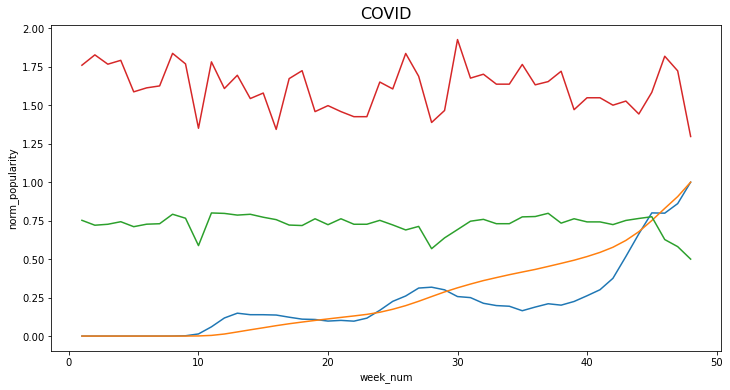

In [504]:
plt.figure(figsize=(12,6))
plt.title("COVID", fontsize=16)
sns.lineplot(data=merged, x='week_num', y='norm_positive_i')
sns.lineplot(data=merged, x='week_num', y='norm_positive')
sns.lineplot(data=merged, x='week_num', y='danceability') 
sns.lineplot(data=merged, x='week_num', y='norm_popularity')
# sns.lineplot(data=merged, x='week_num', y='instrumentalness')


x = range(0, len(merged.week_num))
cases_reg = np.polyfit(x, merged.norm_positive_i, 1)
cases_line = np.poly1d(cases_reg)

x = range(0, len(merged.week_num))
popularity_reg = np.polyfit(x, merged.popularity, 1)
pop_line = np.poly1d(popularity_reg)

x = range(0, len(merged.week_num))
dance_reg = np.polyfit(x, merged.danceability, 1)
dance_line = np.poly1d(dance_reg)


print(f'Slope of trend in positive COVID cases: {cases_line.c[0]}')
print(f'Slope of trend in popularity of top songs: {pop_line.c[0]}')
print(f'Slope of trend in danceability of top songs: {dance_line.c[0]}')

###  note for analysis: Possibility that energy and # of positive cases increases bc more ppl are going out and partying which causes cases to increase in the first place ??

plt.show()

## Pre-COVID vs. During COVID

Now we'll extract Spotify's Top 10 song data from before COVID to compare how trends changed throughout the year before COVID 
Starting on 2/15/19 until 2/25/20 the beginning of COVID in the U.S. (when we had our first positive cases)

In [505]:
pre_spotify = pd.read_csv('pre_data.csv')
pre_spotify.sort_values(by=['start_date'], inplace=True)

In [506]:

# We want to analyze Spotify data from January 2019 to January 2020 to compare to Spotify data when the first tests were administered
i = pd.to_datetime('01/11/2019')
pre_bins = []
while i < pd.to_datetime('01/04/2020'):
    temp = i + pd.Timedelta('7 days')
    pre_bins.append((i,temp))
    i = temp
pre_bins = pd.IntervalIndex.from_tuples(pre_bins)

In [507]:

pre_spotify['start_date'] = pd.to_datetime(pre_spotify['start_date'])

# Using the interval index created above, create a new column week which has the week interval of the data
pre_spotify['week'] = pd.cut(pre_spotify['start_date'], pre_bins)

# Now that every row has a week interval, they will be grouped with the total for each column 
pre_spotify = pre_spotify.groupby(['week']).mean().reset_index()

# Number the weeks to easily identify
pre_spotify['week_num'] = list(range(1,len(pre_bins)+1))
pre_spotify = pre_spotify.reset_index()
grouped_pre = pre_spotify[:52]

In [508]:
pre_spotify = grouped_pre.groupby(['week_num']).mean()
pre_spotify.head()

,index,length,popularity,danceability,acousticness,danceability.1,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
week_num,,,,,,,,,,,,,
1,0,194228.5,61.3,0.8066,0.268243,0.8066,0.5552,0.000001,0.16057,-6.4254,0.15057,105.0623,4.0
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4,193647.6,63.8,0.7991,0.255160,0.7991,0.5111,0.000125,0.16664,-7.8419,0.14818,114.6845,4.0


In [509]:
# during_spotify = grouped_spotify
# during_spotify = during_spotify.reset_index()


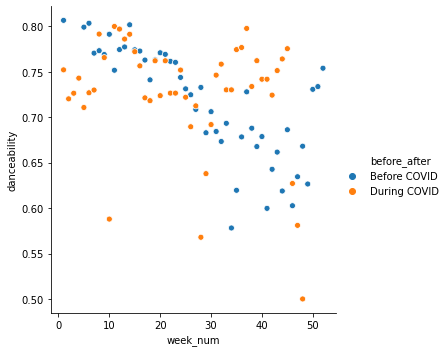

In [510]:
# How do the trends in top Spotify songs compare to trends pre-COVID?

grouped_spotify['week_num'] = list(range(1,len(grouped_spotify)+1))

temp1 = grouped_pre
temp2 = grouped_spotify
temp1["before_after"] = np.array("Before COVID")
temp2["before_after"] = np.array("During COVID")

all_spotify = temp1.append(temp2)

sns.relplot(y="danceability", x="week_num", hue="before_after", data=all_spotify)

# Pre-COVID significantly higher danceability and energy
# Speaks to what artists are writing/producing as well as what ppl are listening to

# blue is pre-covid

Top 10 songs on Spotify pre-COVID:
	Slope of trend of danceability: nan		 Standard deviation of danceability: 0.06105913598090537

Top 10 songs on Spotify during COVID:
	Slope of trend in danceability: -0.00115955818497613		 Standard deviation of danceability: 0.06294661784158888


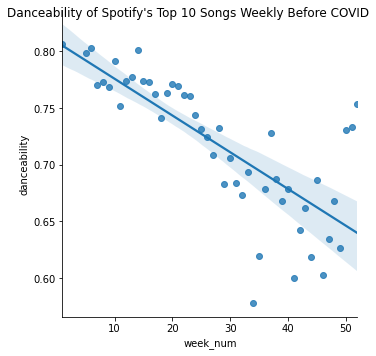

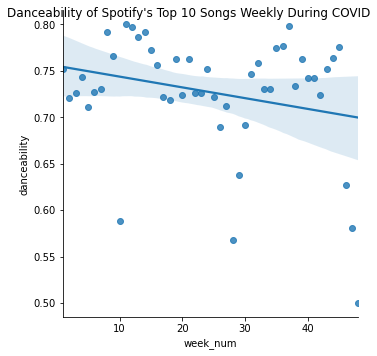

In [511]:
pre_spotify.reset_index(inplace=True)
fig = sns.lmplot(y="danceability", x="week_num", data=pre_spotify);
fig = fig.fig
fig.suptitle("Danceability of Spotify's Top 10 Songs Weekly Before COVID")

fig = sns.lmplot(y="danceability", x="week_num", data=grouped_spotify);
fig = fig.fig
fig.suptitle("Danceability of Spotify's Top 10 Songs Weekly During COVID")


x = range(0, len(pre_spotify.week_num))
pre_reg = np.polyfit(x, pre_spotify.danceability, 1)
pre_line = np.poly1d(pre_reg)

x = range(0, len(grouped_spotify.week_num))
during_reg = np.polyfit(x, grouped_spotify.danceability, 1)
during_line = np.poly1d(during_reg)


print('Top 10 songs on Spotify pre-COVID:')
print(f'\tSlope of trend of danceability: {pre_line.c[0]}\t\t Standard deviation of danceability: {pre_spotify.danceability.std()}\n')

print('Top 10 songs on Spotify during COVID:')
print(f'\tSlope of trend in danceability: {during_line.c[0]}\t\t Standard deviation of danceability: {grouped_spotify.danceability.std()}')


## Predicting Trends Future Trends

We already examined the relationship between the number of positive COVID cases and characteristics of top 10 Spotify songs and found that there is a predictive relationship between the number of positive COVID cases and the danceability and popularity of Spotify's top 10 songs based on their correlation coefficients. There also is a predictive relationship between the increase in number of positive cases and the danceability and popularity of these songs.

Let's predict how these trends will continue as the pandemic progresses.


We'll use sklearn to conduct our machine learning regression algorithm. Since


<ipython-input-512-a8d66cea446a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['dance'] = y_train.values


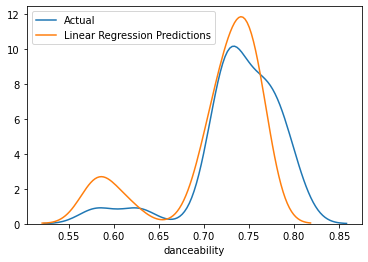

In [512]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

X = grouped_covid.reset_index()[['positive', 'positiveIncrease']]
y = grouped_spotify['danceability']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.5)
X_train['dance'] = y_train.values
print(X_train)
lr = smf.ols(formula='dance ~ positive + positiveIncrease', data=X_train).fit()
preds_lr = lr.predict(X_test)

f, ax = plt.subplots()
sns.distplot(y_test, hist=False, label="Actual", ax=ax)
sns.distplot(preds_lr, hist=False, label="Linear Regression Predictions", ax=ax)

In [513]:
from scipy.stats import f

# F-Test to evaluate goodness of fit

test = lr.f_test(np.identity(len(lr.params)))
print(' Model - Calculated F-Statistic: ' + str(f.ppf(.95,test.df_num,test.df_denom)) + \
    ' F-Value: ' + str(test.fvalue[0][0]) + ' P-Value: ' + str(test.pvalue))

 Model - Calculated F-Statistic: 3.4668001115424154 F-Value: 967.2238306995116 P-Value: 2.114547928505607e-21


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


      positive  positiveIncrease   pop
18  10736838.0            157583  86.9
23  16354229.0            244728  88.9
16   8458881.0            179166  81.7
28  30296402.0            439179  79.0
44  79323733.0           1169882  94.3
26  23885427.0            456038  67.2
7       1227.0               419  70.2
24  18408924.0            329827  89.4
29  33137630.0            375242  91.3
30  35709063.0            365302  87.5
43  71671302.0            971012  95.3
12   2828628.0            217297  87.7
41  60987944.0            548531  93.0
3         23.0                 3  80.7
9      80769.0             20212  81.4
10    460837.0             87791  85.9
20  12820064.0            148875  86.6
34  43975397.0            240764  90.8
0          0.0                 0  84.9
40  57452201.0            440054  91.4
19  11782326.0            142362  80.3
45  87662357.0           1167379  90.8
25  20904154.0            380785  47.7
1         10.0                 2  80.8


<ipython-input-516-5e1557e12e42>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['pop'] = y_train.values


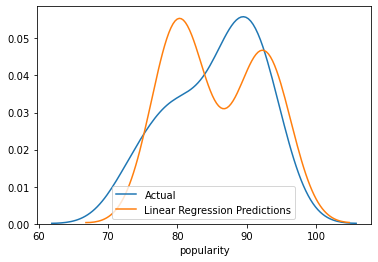

In [516]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

X = grouped_covid.reset_index()[['positive', 'positiveIncrease']]
y = grouped_spotify['popularity']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.5)
X_train['pop'] = y_train.values

lr = smf.ols(formula='pop ~ positive + positiveIncrease', data=X_train).fit()
preds_lr = lr.predict(X_test)

f, ax = plt.subplots()
sns.distplot(y_test, hist=False, label="Actual", ax=ax)
sns.distplot(preds_lr, hist=False, label="Linear Regression Predictions", ax=ax)

In [517]:
# F-Test to evaluate goodness of fit

test = lr.f_test(np.identity(len(lr.params)))
print(' Model - Calculated F-Statistic: ' + str(f.ppf(.95,test.df_num,test.df_denom)) + \
    ' F-Value: ' + str(test.fvalue[0][0]) + ' P-Value: ' + str(test.pvalue))

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


AttributeError: 'Figure' object has no attribute 'ppf'

These models for predicting the characteristics of trending songs using positive COVID cases as a predictor 
is statistically significant.
The F-Values are greater than the F-Statistics and all p-values are <0.05